# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import imageio
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# 높은 해상도 사진

In [2]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [3]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [4]:
img_path = os.getenv('HOME') + '/aiffel/super_resolution/data/image.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [5]:
## bicubic interpolation
bicubic_lr = cv2.resize(
    img, 
    dsize=(img.shape[1]//4, img.shape[0]//4), # 저해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

bicubic_hr = cv2.resize(
    bicubic_lr, 
    dsize=(img.shape[1], img.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

In [6]:
sr = apply_srgan(bicubic_lr)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


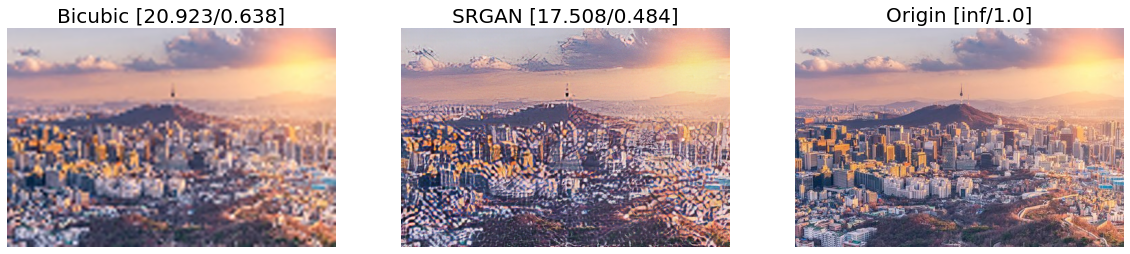

In [7]:
images = [bicubic_hr, sr, img]
labels = ["Bicubic", "SRGAN", "Origin"]

psnr = [round(peak_signal_noise_ratio(img, i), 3) for i in images]
ssim = [round(structural_similarity(img, i, multichannel=True), 3) for i in images]

plt.figure(figsize=(20,15))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)
    plt.axis('off')

- SRGAN에 심한 노이즈등이 생긴다. 

# 낮은 해상도 사진

In [8]:
img2_path = os.getenv('HOME') + '/aiffel/super_resolution/data/image2.jpg'
img2 = cv2.imread(img2_path)

In [9]:
## bicubic interpolation
bicubic_hr_img = cv2.resize(
    img2, 
    dsize=(img2.shape[1]*4, img2.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

In [10]:
sr_img2 = apply_srgan(img2)

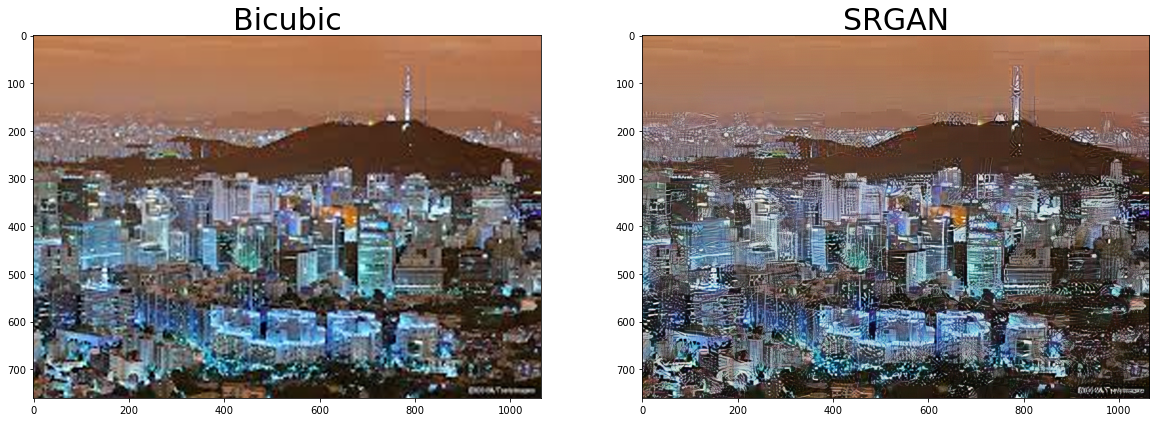

In [11]:
img2 = [bicubic_hr_img, sr_img2]
labels = ["Bicubic", "SRGAN"]

plt.figure(figsize=(20,10))
for i in range(2):
    plt.subplot(1,2,i+1) 
    plt.imshow(img2[i])
    plt.title(labels[i], fontsize=30)

- SRGAN이 bicubic보다 좀더 선명하게 보인다. 

# gif

In [12]:
gif_path = os.getenv('HOME') + '/aiffel/super_resolution/data/city_night_lr.gif'
gif = cv2.VideoCapture(gif_path)

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


In [13]:
# bicubic
frames_bicubic = []
for frame in frames:
    frames_sr = cv2.resize(
    frame,
    dsize=(1420, 1360), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC) # bicubic 설정
    frames_bicubic.append(frames_sr)

In [14]:
gif_bicubic = os.getenv('HOME') + '/aiffel/super_resolution/data/wine_bicubic.gif'
imageio.mimsave(gif_bicubic, frames_bicubic)

In [15]:
# srgan
frames_srgan = []
for frame in frames:
    frames_sr = apply_srgan(frame)
    frames_srgan.append(frames_sr)

In [16]:
gif_sr= os.getenv('HOME') + '/aiffel/super_resolution/data/wine_srgan.gif'
imageio.mimsave(gif_sr, frames_srgan)

In [17]:
from IPython.display import Image as show_gif
show_gif(gif_sr, width = 350)

- 기존보다 좀더 선명하게 보인다.